### Neural Networks to fit $z = \tan(\theta)$ and $\theta = \arctan(z)$

In [1]:
# Library imports
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time

# Aliases
keras = tf.keras

In [2]:
# Local imports
from utils import gpu_grow_memory, TimeHistory, EpochLoss, plot_loss_hist
from utils import load_vartbl, save_vartbl, plot_style
from utils import make_model_pow, make_features_pow

from polar_coord import make_data_tan, make_dataset_tan
from polar_coord import make_models_tan_math
from polar_coord import compile_and_fit#, make_model_autoencoder

In [3]:
# Grow GPU memory (must be first operation in TF)
gpu_grow_memory()

In [4]:
# Plot style 
plot_style()

In [5]:
# Lightweight serialization
fname = '../pickle/polar_coord.pickle'
vartbl = load_vartbl(fname)

## Create datasets for $\theta \in [0, \pi]$ and $x \in [-1, 1]$

In [6]:
# Make datasets for tan
n = 36000
data_tan = make_data_tan(n)
ds_p2c, ds_c2p, ds_p2p, ds_c2c = make_dataset_tan(n=n, batch_size=3600)

In [7]:
# Set number of epochs
epoch_size = n
epochs = (20000 * 3600) // n
samples_total = epochs * epoch_size

# Set save_freq in terms of SAMPLES
save_freq = samples_total // 10

# Print summary
print(f'Built data set with n={n:,}.')
print(f'Training for {epochs} epochs total, with {samples_total:,} sample points total.')
print(f'Save frequency every {save_freq:,} samples.')

Built data set with n=36,000.
Training for 2000 epochs total, with 72,000,000 sample points total.
Save frequency every 7,200,000 samples.


In [8]:
# # Unpack one example batch
# batch_theta, batch_z = list(ds_p2c.take(10))[0]
# batch_theta, batch_z = batch_theta.numpy(), batch_z.numpy()

# # Review data contents
# print(f'batch size: {batch_theta.shape[0]}')
# print(f'theta: min={np.min(batch_theta):+8.5}, max={np.max(batch_theta):+8.5}')
# print(f'    z: min={np.min(batch_z):+8.5}, max={np.max(batch_z):+8.5}')

In [9]:
theta = data_tan['theta']
z = data_tan['z']

## Deterministic Mathematical Models

In [10]:
# Mathematical models
math_p2c, math_c2p, math_p2p, math_c2c = make_models_tan_math()

In [11]:
# Set loss function and optimizer
loss = keras.losses.MeanSquaredError()
optimizer = keras.optimizers.Adam()
metrics = [keras.metrics.MeanAbsoluteError()]

In [12]:
# Compile the math models
math_p2c.compile(loss=loss, optimizer=optimizer, metrics=metrics)
math_c2p.compile(loss=loss, optimizer=optimizer, metrics=metrics)
math_p2p.compile(loss=loss, optimizer=optimizer, metrics=metrics)
math_c2c.compile(loss=loss, optimizer=optimizer, metrics=metrics)

In [13]:
# Evaluate the p2c math model
math_p2c.evaluate(ds_p2c)

10/10 [==============================] - 0s 17ms/step - loss: 2.1804e-10 - mean_absolute_error: 2.5989e-07


[2.180350409768106e-10, 2.5988868e-07]

In [14]:
# Evaluate the c2p math model
math_c2p.evaluate(ds_c2p)

10/10 [==============================] - 0s 17ms/step - loss: 9.5379e-16 - mean_absolute_error: 1.1902e-08


[9.537918417257095e-16, 1.1901681e-08]

In [15]:
# Evaluate the p2p math model
math_p2p.evaluate(ds_p2p)

10/10 [==============================] - 0s 16ms/step - loss: 1.2998e-15 - mean_absolute_error: 1.6133e-08


[1.2998067117971785e-15, 1.6132784e-08]

In [16]:
# Evaluate the c2c math model
math_c2c.evaluate(ds_c2c)

10/10 [==============================] - 0s 16ms/step - loss: 2.1806e-10 - mean_absolute_error: 2.9743e-07


[2.1806388395299511e-10, 2.9742677e-07]

## Functions for visualizing neural network outputs $z = \tan(\theta)$

In [17]:
def plot_pred_tan(model, theta):
    # Predictions of the model
    z_pred = model.predict(theta)
    z_pred = z_pred.reshape((-1,))
    
    # Plot predictions
    fig, ax = plt.subplots(figsize=[16,9])
    ax.set_title(f'$z = \\tan(\\theta)$ in {model.name}')
    ax.set_xlabel('$\\theta$')
    ax.set_ylabel('$z$')
    ax.set_xlim(-np.pi/2, np.pi/2)
    ax.set_xticks(np.linspace(-np.pi/2.0, np.pi/2.0, 5))
    ax.set_xticklabels(['$-\pi/2$', '$-\pi/4$', '$0$', '$\pi/4$', '$\pi/2$'])
    ax.set_ylim(-10.0, 10.0)
    # ax.set_yticks(np.linspace(-1.0, 1.0, 9))
    ax.plot(theta, z, color='blue', label='$\\tan(\\theta)$', linewidth=4.0)
    ax.plot(theta, z_pred, color='red', label='NN$(\\theta)$', linewidth=2.0)
    ax.grid()
    ax.legend()
    return fig, ax

In [18]:
def plot_error_tan(model, theta):
    # Predictions of the model
    z_pred = model.predict(theta)
    z_pred = z_pred.reshape((-1,))
    error = z_pred - np.tan(theta)
    error_rel = error / (1.0 + np.abs(np.tan(theta)))
    
    # Plot errors
    fig, ax = plt.subplots(figsize=[16,9])
    ax.set_title(f'Error for $z = \\tan(\\theta)$ in {model.name}')
    ax.set_xlabel('$\\theta$')
    ax.set_ylabel('rel error = $\epsilon / (1 + |\\tan(\\theta)|)$')
    ax.set_xlim(-np.pi/2, np.pi/2)
    ax.set_xticks(np.linspace(-np.pi/2.0, np.pi/2.0, 5))
    ax.set_xticklabels(['$-\pi/2$', '$-\pi/4$', '$0$', '$\pi/4$', '$\pi/2$'])
    ax.plot(theta, error_rel, color='red', label='error', linewidth=4.0)
    ax.grid()
    # ax.legend()
    return fig, ax

## Neural networks for $z = \tan(\theta)$

### Network Design 0: [ ]
model_tan_ has only feature augmentation layers with odd powers of theta

In [19]:
# Build the NN model of z=tan(theta)
model_tan_ = make_model_pow(func_name='tan', 
                            input_name='theta',
                            output_name='z',
                            powers=[1,3,5,7],
                            skip_layers=False,
                            hidden_sizes=[])

model_tan_.compile(loss=loss, optimizer=optimizer, metrics=metrics)

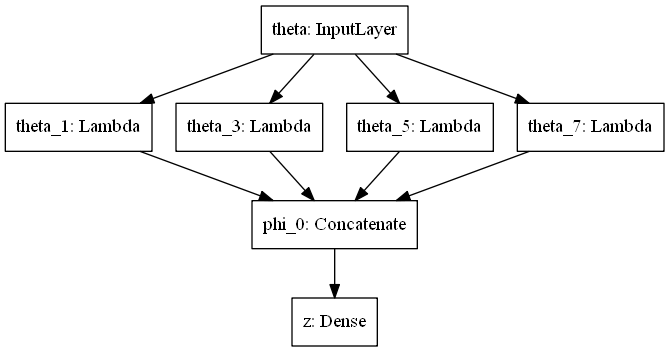

In [20]:
keras.utils.plot_model(model_tan_, show_shapes=False)

In [21]:
model_tan_.summary()

Model: "model_tan_[]"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
theta (InputLayer)              [(None, 1)]          0                                            
__________________________________________________________________________________________________
theta_1 (Lambda)                (None, 1)            0           theta[0][0]                      
__________________________________________________________________________________________________
theta_3 (Lambda)                (None, 1)            0           theta[0][0]                      
__________________________________________________________________________________________________
theta_5 (Lambda)                (None, 1)            0           theta[0][0]                      
_______________________________________________________________________________________

In [22]:
# loss=keras.losses.MeanSquaredError()
loss=keras.losses.MeanSquaredLogarithmicError()
optimizer=keras.optimizers.Adam(learning_rate=1.0E-3)

try:
    model_tan_.load_weights('../models/polar/model_tan_[].h5')
    model_tan_.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    hist_tan_ = vartbl['hist_tan_']
    print('Loaded model_tan_.')
except:
    hist = compile_and_fit(model=model_tan_, 
                           ds=ds_p2c, 
                           epochs=epochs,
                           loss=loss, 
                           optimizer=optimizer,
                           metrics=metrics,
                           save_freq=save_freq)
    hist_tan_ = hist.history
    vartbl['hist_tan_'] = hist_tan_
    save_vartbl(vartbl, fname)

Loaded model_tan_.


In [23]:
model_tan_.evaluate(ds_p2c)

10/10 [==============================] - 1s 60ms/step - loss: 0.0803 - mean_absolute_error: 5.6458


[0.08030335605144501, 5.6457663]

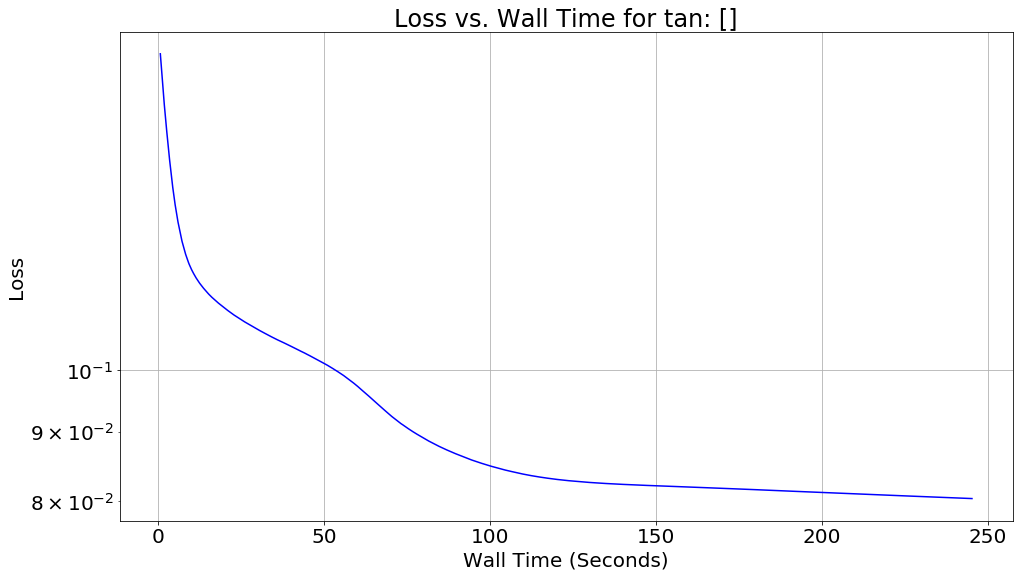

In [24]:
fig, ax = plot_loss_hist(hist_tan_, 'tan: []')

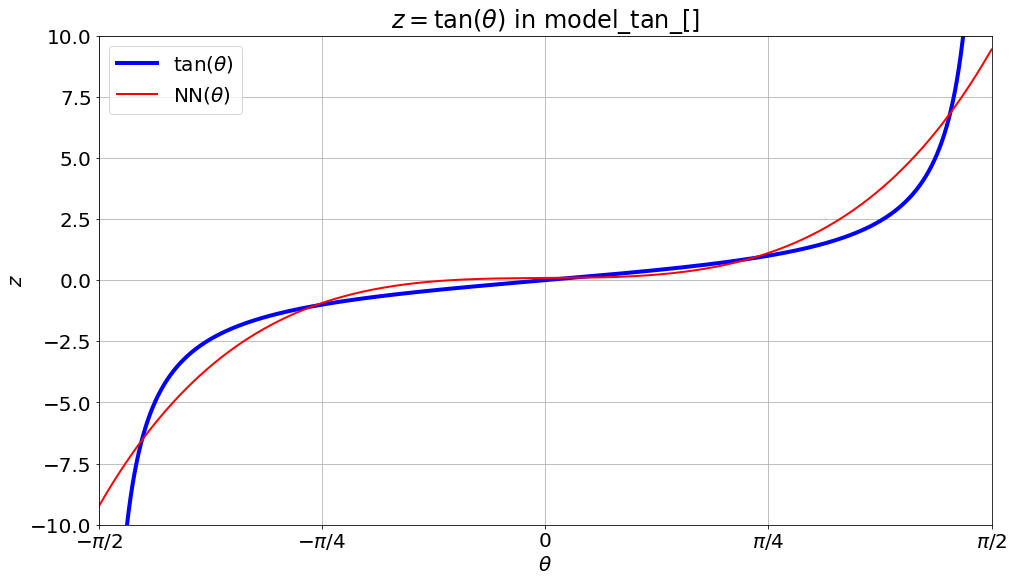

In [25]:
fig, ax = plot_pred_tan(model_tan_, theta)

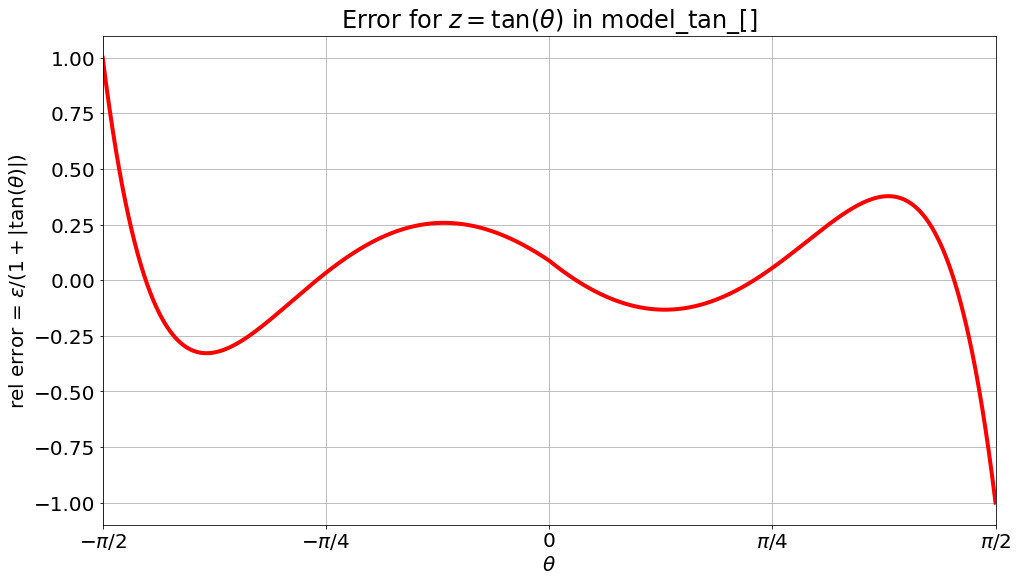

In [26]:
fig, ax = plot_error_tan(model_tan_, theta)

### Network Design 1: [64]
(model_tan_64 has one layer with 64 hidden units)

In [27]:
# Build the NN model of z=tan(theta)
model_tan_64 = make_model_pow(func_name='tan', 
                              input_name='theta',
                              output_name='z',
                              powers=[1,3,5,7,9,11,13],
                              skip_layers=True,
                              hidden_sizes=[64])

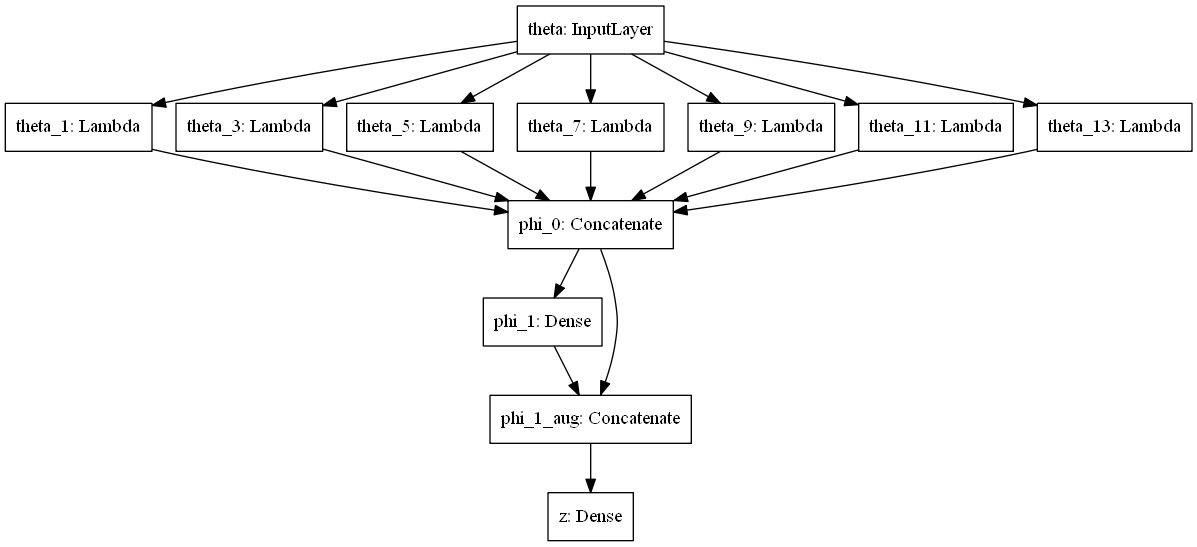

In [28]:
keras.utils.plot_model(model_tan_64, show_shapes=False)

In [29]:
model_tan_64.summary()

Model: "model_tan_[64]"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
theta (InputLayer)              [(None, 1)]          0                                            
__________________________________________________________________________________________________
theta_1 (Lambda)                (None, 1)            0           theta[0][0]                      
__________________________________________________________________________________________________
theta_3 (Lambda)                (None, 1)            0           theta[0][0]                      
__________________________________________________________________________________________________
theta_5 (Lambda)                (None, 1)            0           theta[0][0]                      
_____________________________________________________________________________________

**Load the network and its loss history if available; otherwise train it**

In [30]:
# loss=keras.losses.MeanSquaredError()
loss=keras.losses.MeanSquaredLogarithmicError()
optimizer=keras.optimizers.Adam(learning_rate=1.0E-3)

try:
    model_tan_64.load_weights('../models/polar/model_tan_[64].h5')
    model_tan_64.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    hist_tan_64 = vartbl['hist_tan_64']
    print('Loaded model_tan_64.')
except:
    hist = compile_and_fit(model=model_tan_64, 
                           ds=ds_p2c, 
                           epochs=epochs,
                           loss=loss, 
                           optimizer=optimizer,
                           metrics=metrics,
                           save_freq=save_freq)
    hist_tan_64 = hist.history
    vartbl['hist_tan_64'] = hist_tan_64
    save_vartbl(vartbl, fname)

Loaded model_tan_64.


In [31]:
model_tan_64.evaluate(ds_p2c)

10/10 [==============================] - 0s 28ms/step - loss: 0.0156 - mean_absolute_error: 5.3502


[0.015629510395228863, 5.350163]

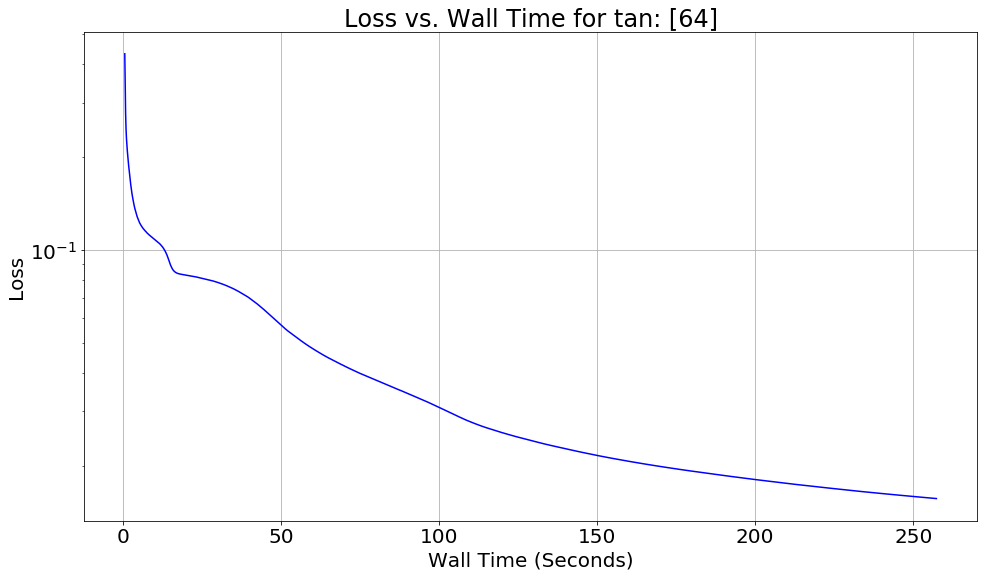

In [32]:
fig, ax = plot_loss_hist(hist_tan_64, 'tan: [64]')

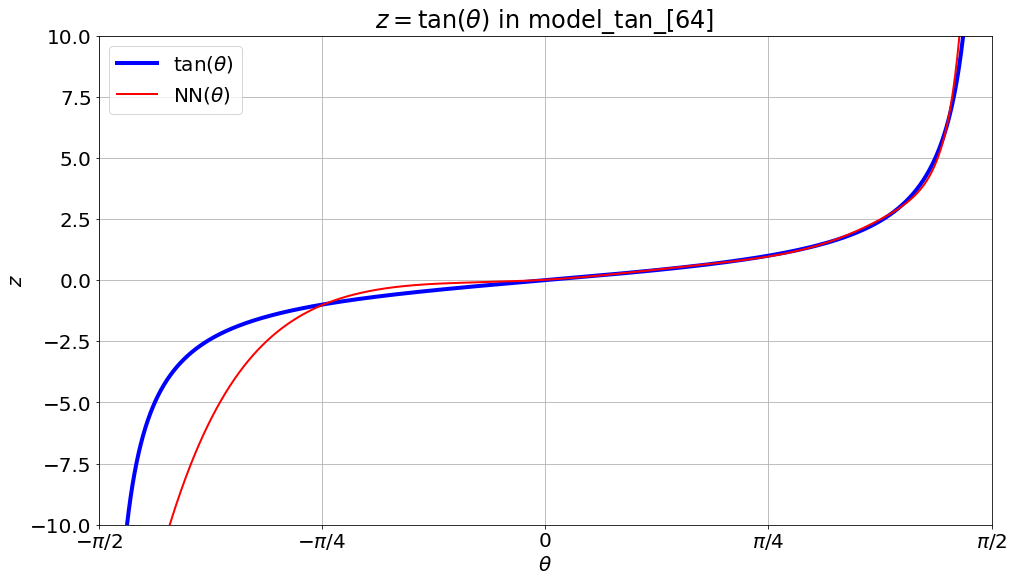

In [33]:
fig, ax = plot_pred_tan(model_tan_64, theta)

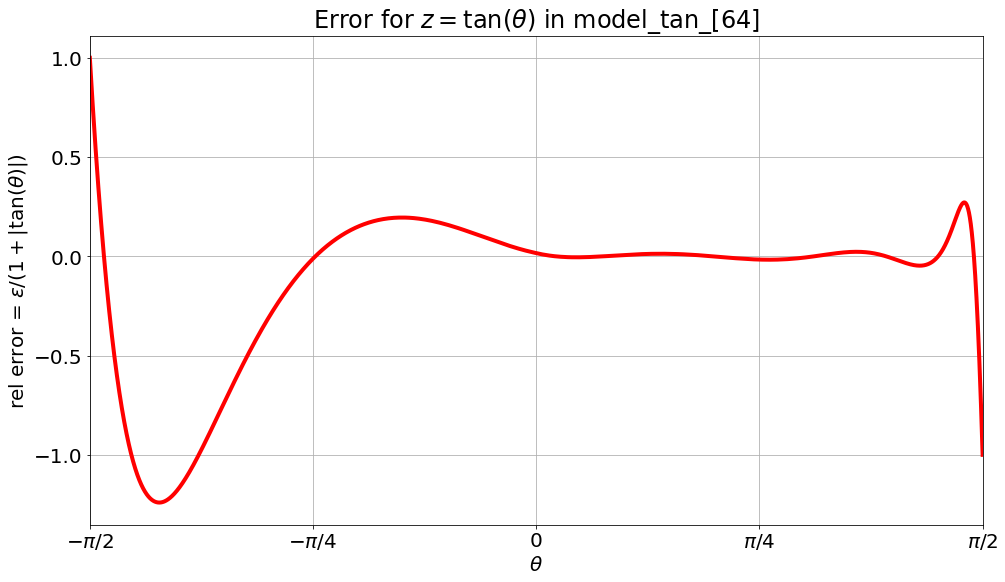

In [34]:
fig, ax = plot_error_tan(model_tan_64, theta)

### Network Design 2: [16, 16]
(model_tan_16_16 has two layers with 16 hidden units each)

In [35]:
model_tan_16_16 = make_model_pow(func_name='tan', 
                              input_name='theta',
                              output_name='z',
                              powers=[1,3,5,7,9,11,13],
                              skip_layers=True,
                              hidden_sizes=[16, 16])

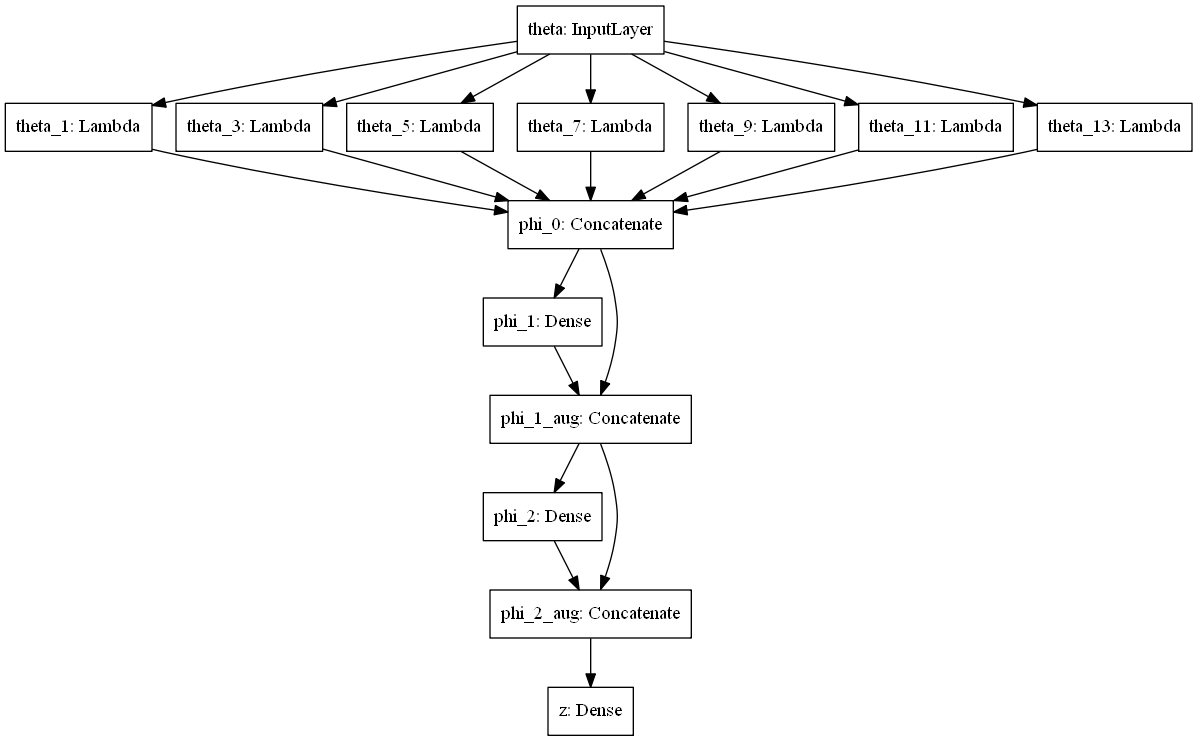

In [36]:
keras.utils.plot_model(model_tan_16_16)

In [37]:
model_tan_16_16.summary()

Model: "model_tan_[16, 16]"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
theta (InputLayer)              [(None, 1)]          0                                            
__________________________________________________________________________________________________
theta_1 (Lambda)                (None, 1)            0           theta[0][0]                      
__________________________________________________________________________________________________
theta_3 (Lambda)                (None, 1)            0           theta[0][0]                      
__________________________________________________________________________________________________
theta_5 (Lambda)                (None, 1)            0           theta[0][0]                      
_________________________________________________________________________________

**Load the network and its loss history if available; otherwise train it**

In [38]:
# loss=keras.losses.MeanSquaredLogarithmicError()
loss=keras.losses.MeanAbsolutePercentageError()
optimizer=keras.optimizers.Adam(learning_rate=1.0E-3)

try:
    model_tan_16_16.load_weights('../models/polar/model_tan_[16, 16].h5')
    model_tan_16_16.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    hist_tan_16_16 = vartbl['hist_tan_16_16']
    print('Loaded model_tan_16_16.')
except:
    hist = compile_and_fit(model=model_tan_16_16, 
                           ds=ds_p2c, 
                           epochs=epochs,
                           loss=loss, 
                           optimizer=optimizer,
                           metrics=metrics,
                           save_freq=save_freq)
    hist_tan_16_16 = hist.history
    vartbl['hist_tan_16_16'] = hist_tan_16_16
    save_vartbl(vartbl, fname)

Loaded model_tan_16_16.


In [39]:
model_tan_16_16.evaluate(ds_p2c)

10/10 [==============================] - 0s 29ms/step - loss: 552.4875 - mean_absolute_error: 16.6887


[552.4875305175781, 16.688671]

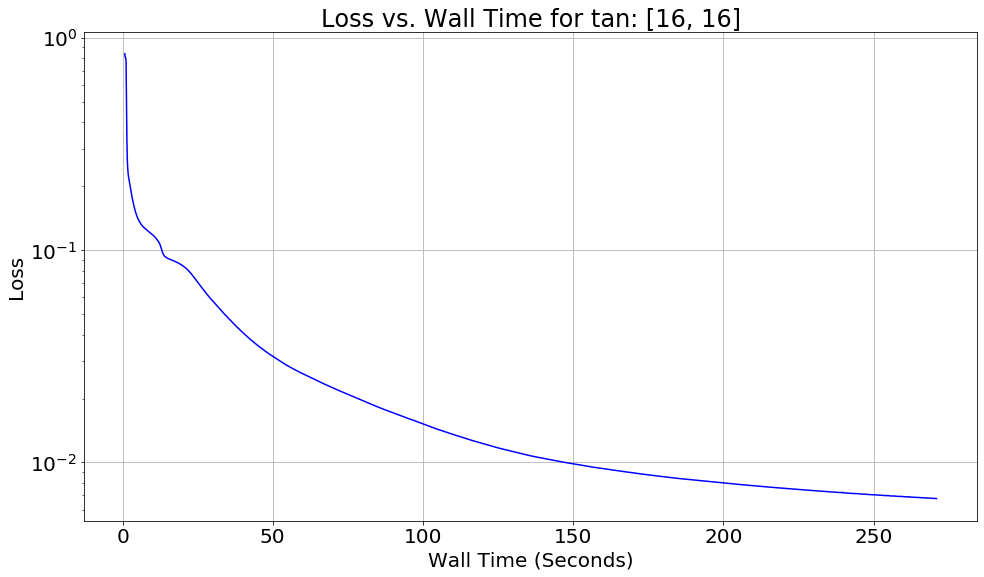

In [40]:
fig, ax = plot_loss_hist(hist_tan_16_16, 'tan: [16, 16]')

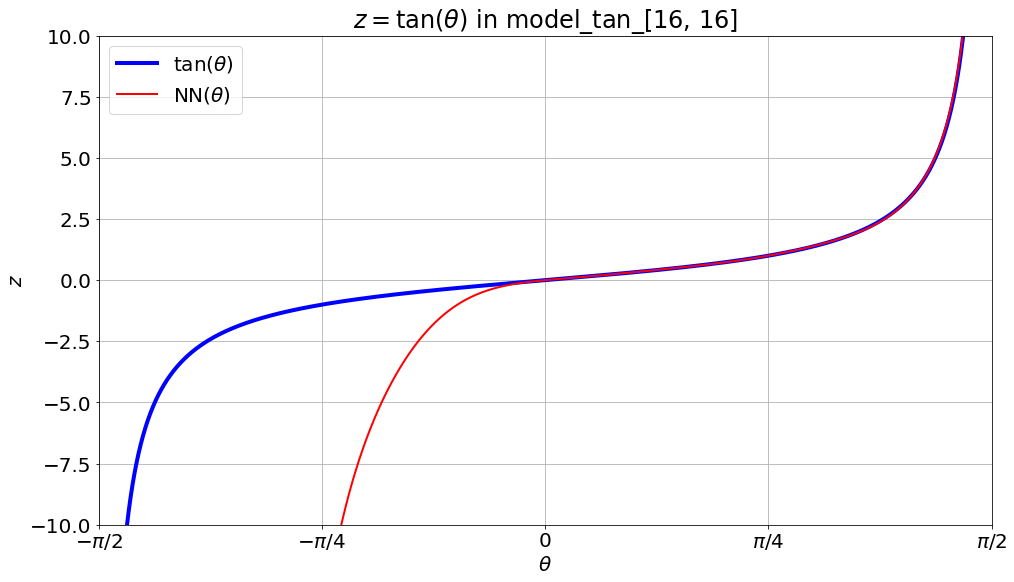

In [41]:
fig, ax = plot_pred_tan(model_tan_16_16, theta)

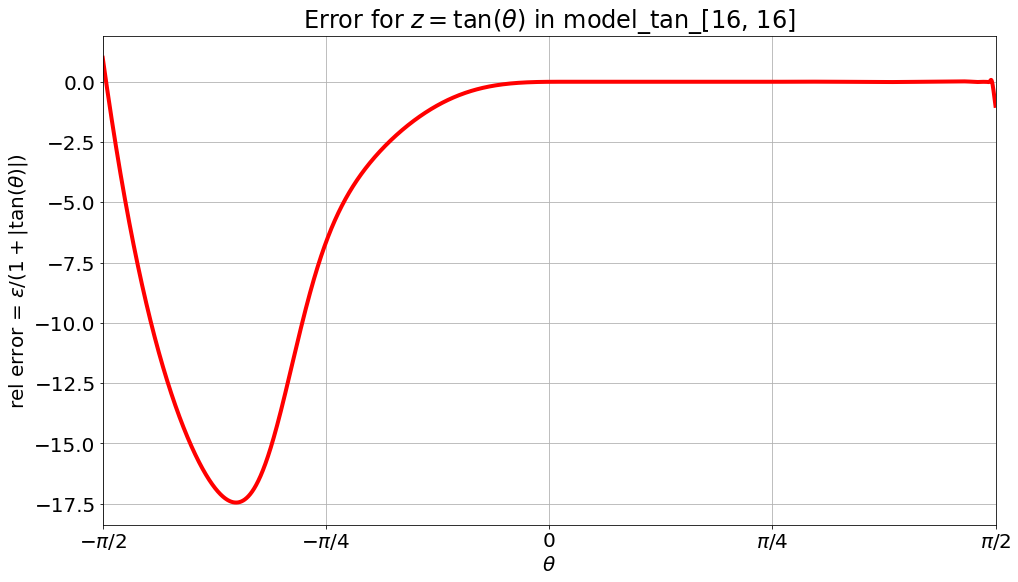

In [42]:
fig, ax = plot_error_tan(model_tan_16_16, theta)

## Neural networks for $\theta = \arctan(z)$

## Functions for visualizing neural network outputs $\theta = \arctan(z)$

In [178]:
def plot_pred_arctan(model, z):
    # Predictions of the model
    theta_pred = model.predict(z)
    theta_pred = theta_pred.reshape((-1,))
    
    # Plot predictions
    fig, ax = plt.subplots(figsize=[16,9])
    ax.set_title(f'$\\theta = \\arctan(z)$ for {model.name}')
    ax.set_xlabel('$z$')
    ax.set_ylabel('$\\theta$')
    ax.set_xlim(-10.0, 10.0)
    # ax.set_xticks(np.linspace(-1.0, 1.0, 9))
    ax.set_ylim(-np.pi/2.0, np.pi/2.0)
    ax.set_yticks(np.linspace(-np.pi/2.0, np.pi/2.0, 5))
    ax.set_yticklabels(['$-\pi/2$', '$-\pi/4$', '$0$', '$\pi/4$', '$\pi/2$'])
    ax.plot(z, theta, color='blue', label='$\\arctan(z)$', linewidth=4.0)
    ax.plot(z, theta_pred, color='red', label='NN$(z)$', linewidth=2.0)
    ax.grid()
    ax.legend()
    return fig, ax

In [179]:
def plot_error_arctan(model, z):
    # Predictions of the model
    theta_pred = model.predict(z)
    theta_pred = theta_pred.reshape((-1,))
    error = theta - theta_pred
    
    # Plot predictions
    fig, ax = plt.subplots(figsize=[16,9])
    ax.set_title(f'Error in $\\theta = \\arctan(z)$ for {model.name}')
    ax.set_xlabel('$z$')
    ax.set_ylabel('$\\theta$')
    ax.set_xlim(-10.0, 10.0)
    # ax.set_xticks(np.linspace(-1.0, 1.0, 9))
    ax.plot(z, error, color='red', label='error', linewidth=4.0)
    ax.grid()
    ax.legend()
    return fig, ax

### Network Design 1: [64]

In [167]:
def make_model_arctan(hidden_sizes, skip_layers):
    """
    Neural net model of arctan function
    """
    # Input layer
    z = keras.Input(shape=(1,), name='z')
    
    # Compute transform z / (1+z^2)
    z_over_1pz2 = keras.layers.Lambda(lambda z : z / (1.0 + z * z), name='z_over_1pz2')(z)
    
    # Compute features in Euler power series expansion of arctan
    f1 = z_over_1pz2
    a0 = f1
    
    f2 = keras.layers.Lambda(lambda f: tf.pow(f, 2), name='f2')(z_over_1pz2)
    a1 = keras.layers.multiply(inputs=[f2, z], name='z3_over_1pz2_2')
    
    f3 = keras.layers.Lambda(lambda f: tf.pow(f, 3), name='f3')(z_over_1pz2)
    z2 = keras.layers.Lambda(lambda z: tf.pow(z, 2), name='z2')(z)
    a2 = keras.layers.multiply(inputs=[f3, z2], name='z5_over_1pz2_3')

    f4 = keras.layers.Lambda(lambda f: tf.pow(f, 4), name='f4')(z_over_1pz2)
    z3 = keras.layers.Lambda(lambda z: tf.pow(z, 3), name='z3')(z)
    a3 = keras.layers.multiply(inputs=[f4, z3], name='z7_over_1pz2_3')

    # Number of hidden layers
    num_layers = len(hidden_sizes)

    # Augmented feature layer - transforms of z^(2n+1) / (1+z^2)^(n+1)
    phi_0 = keras.layers.concatenate([a0, a1, a2, a3], name='phi_0')
    phi_n = phi_0

    # Dense feature layers
    
    # First hidden layer if applicable
    if num_layers > 0:
        phi_1 = keras.layers.Dense(units=hidden_sizes[0], activation='tanh', name='phi_1')(phi_0)
        if skip_layers:
            phi_1 = keras.layers.concatenate(inputs=[phi_0, phi_1], name='phi_1_aug')
        phi_n = phi_1

    # Second hidden layer if applicable
    if num_layers > 1:
        phi_2 = keras.layers.Dense(units=hidden_sizes[1], activation='tanh', name='phi_2')(phi_1)
        if skip_layers:
            phi_2 = keras.layers.concatenate(inputs=[phi_1, phi_2], name='phi_2_aug')
        phi_n = phi_2

    # Output layer
    # y = keras.layers.Dense(units=1, kernel_initializer='zeros', name='theta')(phi_n)
    y = keras.layers.Dense(units=1, name='theta')(phi_n)

    # Wrap into a model
    model_name = f'model_arctan_' + str(hidden_sizes)
    model = keras.Model(inputs=z, outputs=y, name=model_name) 
    return model

In [168]:
model_arctan_64 = make_model_arctan(
    hidden_sizes=[64],
    skip_layers=True)

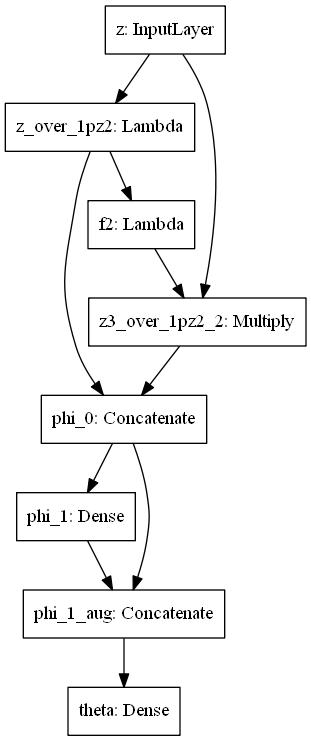

In [169]:
keras.utils.plot_model(model_arctan_64)

In [170]:
model_arctan_64.summary()

Model: "model_arctan_[64]"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
z (InputLayer)                  [(None, 1)]          0                                            
__________________________________________________________________________________________________
z_over_1pz2 (Lambda)            (None, 1)            0           z[0][0]                          
__________________________________________________________________________________________________
f2 (Lambda)                     (None, 1)            0           z_over_1pz2[0][0]                
__________________________________________________________________________________________________
z3_over_1pz2_2 (Multiply)       (None, 1)            0           f2[0][0]                         
                                                                 z[0][0]          

In [174]:
loss=keras.losses.MeanSquaredError()
# loss=keras.losses.MeanAbsoluteError()
optimizer=keras.optimizers.Adam(learning_rate=1.0E-3)

try:
    model_arctan_64.load_weights('../models/polar/model_arctan_[64].h5')
    model_arctan_64.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    hist_arctan_64 = vartbl['hist_arctan_64']
    print('Loaded model_arctan_64.')
except:
    hist = compile_and_fit(model=model_arctan_64, 
                           ds=ds_c2p, 
                           epochs=epochs,
                           loss=loss, 
                           optimizer=optimizer,
                           metrics=metrics,
                           save_freq=save_freq)
    hist_arctan_64 = hist.history
    vartbl['hist_arctan_64'] = hist_arctan_64
    save_vartbl(vartbl, fname)

Epoch 0001; loss 6.03e-01; elapsed 0:00:01
Epoch 0100; loss 2.61e-01; elapsed 0:00:13
Epoch 0200; loss 2.56e-01; elapsed 0:00:25
Epoch 0300; loss 1.20e-01; elapsed 0:00:37
Epoch 0400; loss 1.08e-01; elapsed 0:00:50
Epoch 0500; loss 9.37e-02; elapsed 0:01:02
Epoch 0600; loss 8.63e-02; elapsed 0:01:15
Epoch 0700; loss 7.97e-02; elapsed 0:01:27
Epoch 0800; loss 7.29e-02; elapsed 0:01:40
Epoch 0900; loss 6.61e-02; elapsed 0:01:52
Epoch 1000; loss 6.00e-02; elapsed 0:02:04
Epoch 1100; loss 5.49e-02; elapsed 0:02:16
Epoch 1200; loss 5.05e-02; elapsed 0:02:29
Epoch 1300; loss 4.61e-02; elapsed 0:02:42
Epoch 1400; loss 4.18e-02; elapsed 0:02:54
Epoch 1500; loss 3.86e-02; elapsed 0:03:06
Epoch 1600; loss 3.61e-02; elapsed 0:03:19
Epoch 1700; loss 3.41e-02; elapsed 0:03:31
Epoch 1800; loss 3.23e-02; elapsed 0:03:43
Epoch 1900; loss 3.07e-02; elapsed 0:03:56
Epoch 2000; loss 2.94e-02; elapsed 0:04:08


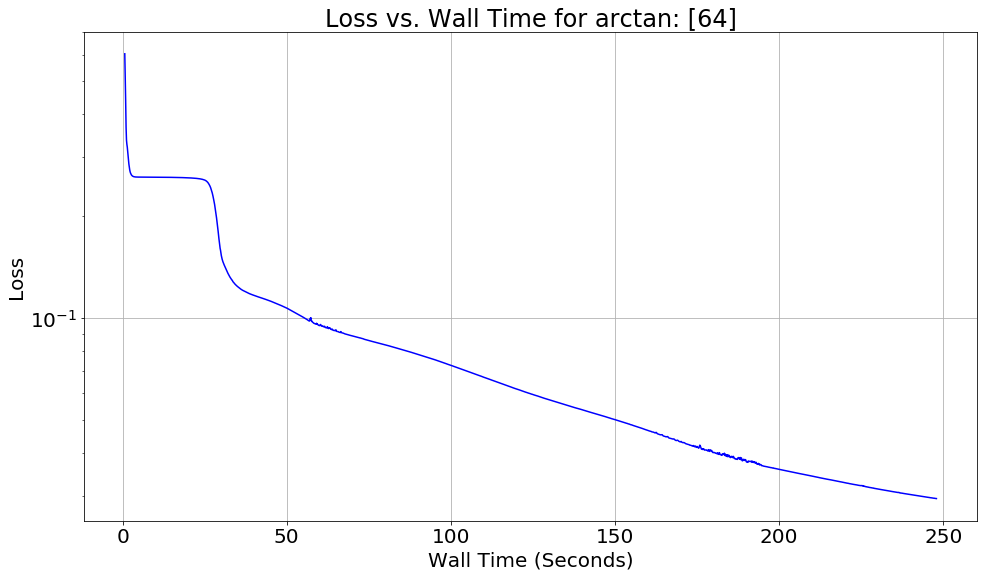

In [175]:
fig, ax = plot_loss_hist(hist_arctan_64, 'arctan: [64]')

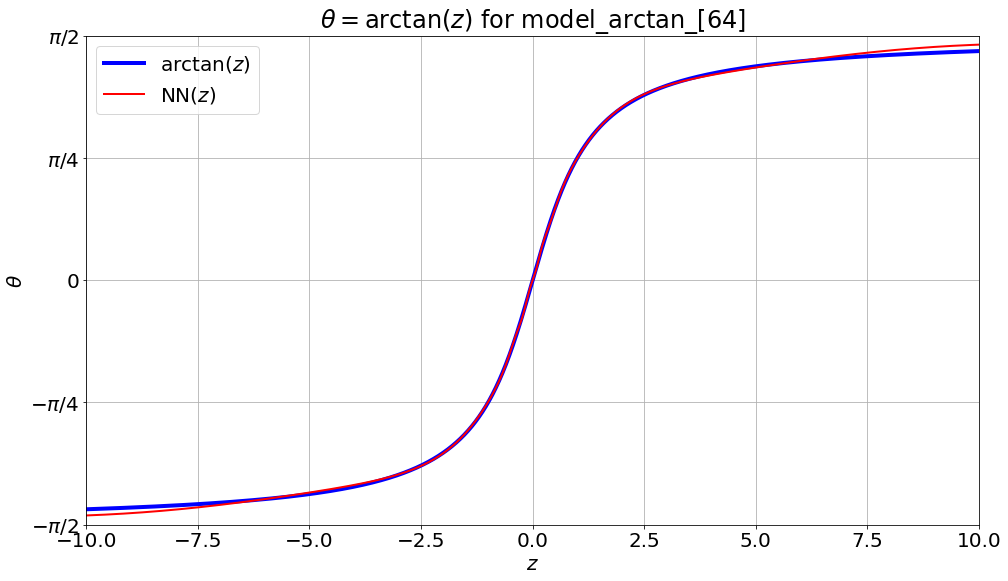

In [180]:
fig, ax = plot_pred_arctan(model_arctan_64, z)

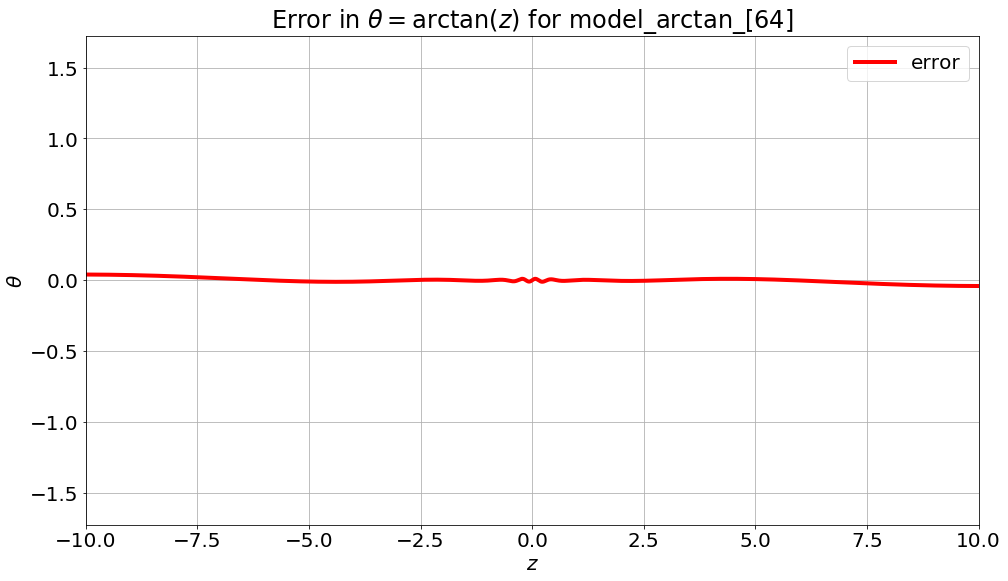

In [182]:
fig, ax = plot_error_arctan(model_arctan_64, z)

### Network Design 2: [16, 16]

In [ ]:
model_arctan_16_16 = make_model_pow(func_name='arctan', 
                                    input_name = 'x',
                                    output_name='theta',
                                    powers=[1,3,5,7],
                                    skip_layers=True,                                    
                                    hidden_sizes=[16, 16])

In [ ]:
keras.utils.plot_model(model_arctan_16_16)

In [ ]:
model_arctan_16_16.summary()

In [ ]:
loss=keras.losses.MeanSquaredError()
optimizer=keras.optimizers.Adam(learning_rate=1.0E-3)

try:
    model_arctan_16_16.load_weights('../models/polar/model_arctan_[16, 16].h5')
    model_arctan_16_16.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    hist_arctan_16_16 = vartbl['hist_arctan_16_16']
    print('Loaded model_arctan_16_16.')
except:
    hist = compile_and_fit(model=model_arctan_16_16, 
                           ds=ds_c2p, 
                           epochs=epochs,
                           loss=loss, 
                           optimizer=optimizer,
                           metrics=metrics,
                           save_freq=save_freq)
    hist_arctan_16_16 = hist.history
    vartbl['hist_arctan_16_16'] = hist_arctan_16_16
    save_vartbl(vartbl, fname)

In [ ]:
model_arctan_16_16.evaluate(ds_c2p)

In [ ]:
fig, ax = plot_loss_hist(hist_arctan_16_16, 'arctan: [16, 16]')

In [ ]:
fig, ax = plot_pred_arctan(model_arctan_16_16, x)

In [ ]:
fig, ax = plot_error_arctan(model_arctan_16_16, x)

In [ ]:
# copies of model instances
model_tan = keras.models.clone_model(model_tan_16_16)
model_tan.set_weights(model_tan_16_16.get_weights())
model_arctan = keras.models.clone_model(model_arctan_16_16)
model_arctan.set_weights(model_arctan_16_16.get_weights())

# remove special characters from model names
# otherwise make_model_autoencoder fails with invalid scope name due to [16, 16] in model names
model_tan._name = 'model_tan'
model_arctan._name = 'model_arctan'

In [ ]:
model_p2p, model_c2c = make_model_autoencoder(
    model_p2c = model_tan,
    model_c2p = model_arctan)

In [ ]:
model_p2p.compile(loss=loss, optimizer=optimizer, metrics=metrics)
model_p2p.evaluate(ds_p2p)

In [ ]:
model_c2c.compile(loss=loss, optimizer=optimizer, metrics=metrics)
model_c2c.evaluate(ds_c2c)